# Justin Barnes

In [1]:
# Imports
%matplotlib inline
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from IPython.display import Image
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook



# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

In [2]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

# The Lagrangian Method

The potential and kinetic energies for the double pendulum system are given by equations (11.37) and (11.38) in Taylor Section 11.4.

<center>$\begin{align}
    U = (m_{1} + m_{2})gL_{1}(1 - \cos\phi_{1}) + m_{2}gL_{2}(1 - \cos\phi_{2}) 
\end{align}$

<center>$\begin{align}
T = \frac{1}{2}(m_{1} + m_{2})L_{1}^{2}\dot\phi_{1}^{2} + m_{2}L_{1}L_{2}\dot\phi_{1}\dot\phi_{2}\cos(\phi_{1} - \phi_{2}) + \frac{1}{2}m_{2}L_{2}^{2}\dot\phi_{2}^{2} 
\end{align}$

Where the Lagrangian is expressed as:

<center>$\begin{align}
    \mathcal{L} = T - U
\end{align}$

The following Euler-Lagrange equations then give the motions of the two pendulums:

<center>$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_{1}} = \frac{\partial\mathcal L}{\partial\phi_{1}}
\end{align}$

<center>$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_{2}} = \frac{\partial\mathcal L}{\partial\phi_{2}}
\end{align}$

The resulting differential equations:
    
<center>$\begin{align}
    0 = (m_{1} + m_{2})L_{1}\ddot\phi_{1} + m_{2}L_{2}\ddot\phi_{2}\cos(\phi_{1} - \phi_{2}) + m_{2}L_{2}\dot\phi_{2}^{2}\sin(\phi_{1} - \phi_{2}) + (m_{1} + m_{2})g\sin(\phi_{1} - \phi_{2})
\end{align}$
<center>$\begin{align}
    0 = m_{2}L_{2}\ddot\phi_{2} + m_{2}L_{1}\ddot\phi_{1}\cos(\phi_{1} - \phi_{2}) - m_{2}L_{1}\dot\phi_{1}^{2}\sin(m_{1} + m_{2}) + m_{2}g\sin\phi_{2}
\end{align}$
    
The differential equation solver uses vectors to solve the equations. Therefore to solve each equation it will be useful to have $y_{1} = \dot\phi_{1}$, $\dot{y_{1}} = \ddot\phi_{1}$, $y_{2} = \dot\phi_{2}$, $\dot{y_{2}} = \ddot\phi_{2}$. From there we can solve for the first derivaties for both $y_{1}$ and $y_{2}$ we get differential equations we can solve with solve_ivp.
    
<center>$\begin{align}
    \dot{y_{1}} = \frac{m_{2}g\sin\phi_{2}\cos(\phi_{1} - \phi_{2}) - (m_{1} + m_{2})g\sin\phi_{1} - m_{2}\sin(\phi_{1} - \phi{2})(L_{1}e_{1}^{2}\cos(\phi_{1} - \phi_{2}) + L_{2}e_{2}^{2})}{L_{1}(m_{1} + m_{2}\sin_{2}(\phi_{1} - \phi_{2}))}
\end{align}$
<center>$\begin{align}
    \dot{y_{2}} = \frac{(m_{1} + m_{2})(L_{1}e_{1}^{2}\sin(\phi_{1} - \phi_{2}) + g\sin\phi_{1}\cos(\phi_{1} - \phi_{2}) - g\sin\phi_{2}) + m_{2}L_{2}e_{2}^{2}\sin(\phi_{1} - \phi_{2})\cos(\phi_{1} - \phi_{2})}{L_{2}(m_{1} + m_{2}\sin^{2}(\phi_{1} - \phi_{2})}
\end{align}$

# Pendulum Class

In [3]:
class DoublePend():
    """
    DoublePend class utilizes the parameters and Lagrange's equations for 
    a double pendulum with no driving or damping of the motion.
    
    
    
    Parameters
    ----------
    m1: float
        mass of the first pendulum bob
    m2: float
        mass of the second pendulum bob
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    g : float
        acceleration due to gravity



    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    
    
    def __init__(self, m1=1., m2=1., L1=1., L2=1., g=1.):
        
        self.m1 = m1
        self.m2 = m2
        self.L1 = L1
        self.L2 = L2
        self.g = g
    
    
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi1, y[1] = phi1dot, y[2] = phi2, and y[3] = phi2dot          
        Returns
        -------
        
        """
        
        phi1, y1, phi2, y2 = y
        
        c = np.cos(phi1 - phi2)
        s = np.sin(phi1 - phi2)
        M = self.m1 + self.m2
        d = self.m1 + self.m2 * s**2
        
        
        y1dot = (self.m2 * self.g * np.sin(phi2) * c - M * self.g * np.sin(phi1) - self.m2 * s * (self.L1 * y1**2 * c + self.L2 * y2**2)) / (self.L1 * d)
        phi1dot = y1
        
        y2dot = (M * (self.L1 * y1**2 * s + self.g * np.sin(phi1) * c - self.g * np.sin(phi2)) + self.m2 * self.L2 * y2**2 * s * c ) / (self.L2 * d)
        phi2dot = y2
        
        return phi1dot, y1dot, phi2dot, y2dot
                 
                 
    
    def solve_ode(self, t_pts, phi1_0, phi1dot_0, phi2_0, phi2dot_0,abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        
        y = [phi1_0, phi1dot_0, phi2_0, phi2dot_0]
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), y, t_eval = t_pts, atol = abserr, rtol = relerr)
        phi1, phi1dot, phi2, phi2dot = solution.y
        
        return phi1, phi1dot, phi2, phi2dot       

# Plotting Function

In [4]:
# Pulled from Taylor Problem 7.42 Juypter Noteboook

def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, color=None, linestyle=None, semilogy=False,
                loglog=False, ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line


def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Initialize Values

In [5]:
t_start = 0
t_end = 50
delta_t = 0.01

t_pts = np.arange(t_start, t_end + delta_t, delta_t)

m1 = 1.
m2 = 1.
L1 = 1.
L2 = 1.
g = 1.

DP = DoublePend(m1 = m1, m2 = m2, L1 = L1, L2 = L2, g = g)

phi1_0 = np.pi/2
phi1dot_0 = 0.
phi2_0 = np.pi
phi2dot_0 = 0.

phi1, phi1dot, phi2, phi2dot = DP.solve_ode(t_pts, phi1_0, phi1dot_0, phi2_0, phi2dot_0)

# Double Pendulum Plot

<bound method Figure.tight_layout of <Figure size 1200x500 with 1 Axes>>

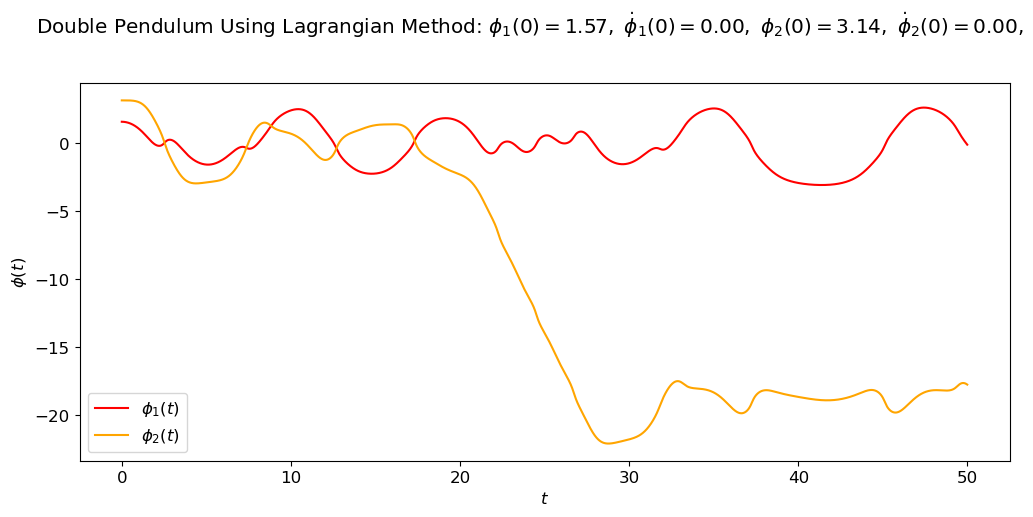

In [10]:
fig = plt.figure(figsize = (12,5))
overall_title = 'Double Pendulum Using Lagrangian Method:' + \
                rf' $\phi_1(0) = {phi1_0 : .2f},$' + \
                rf' $\dot\phi_1(0) = {phi1dot_0 : .2f},$' + \
                rf' $\phi_2(0) = {phi2_0 : .2f},$' + \
                rf' $\dot\phi_2(0) = {phi2dot_0 : .2f},$'

fig.suptitle(overall_title, va = 'baseline')

ax_1 = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], axis_labels = (r'$t$', r'$\phi(t)$'), color = 'red', label = r'$\phi_1(t)$', ax = ax_1)
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], color = 'orange', label = r'$\phi_2(t)$', ax = ax_1)      
            

fig.tight_layout

# Test For Chaos and Sensitivity to Initial Condition

<bound method Figure.tight_layout of <Figure size 1200x500 with 1 Axes>>

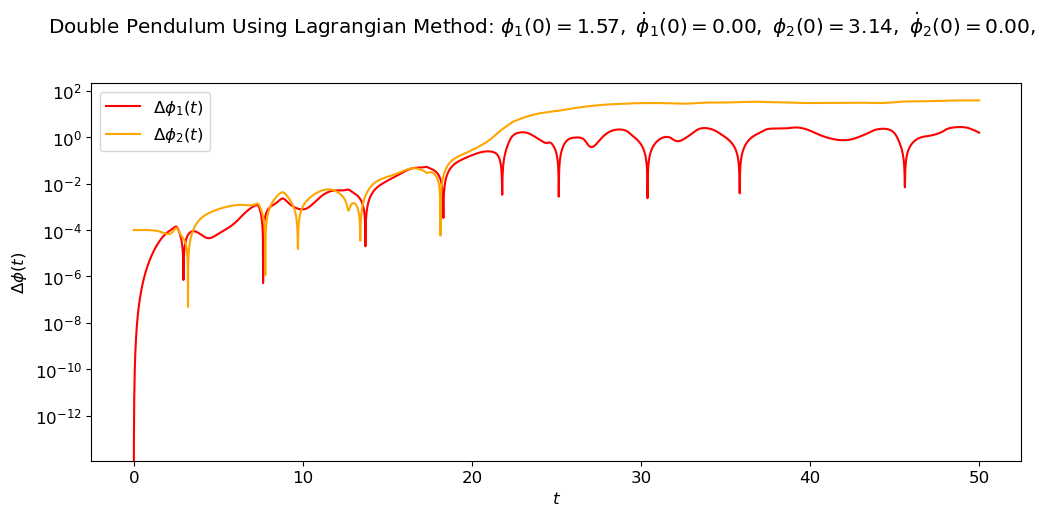

In [13]:
phi1, phi1dot, phi2, phi2dot = DP.solve_ode(t_pts, phi1_0, phi1dot_0, phi2_0, phi2dot_0)
phi1a, phi1adot, phi2a, phi2adot = DP.solve_ode(t_pts, phi1_0, phi1dot_0, phi2_0 - 0.0001, phi2dot_0)


fig = plt.figure(figsize = (12,5))
overall_title = 'Double Pendulum Using Lagrangian Method:' + \
                rf' $\phi_1(0) = {phi1_0 : .2f},$' + \
                rf' $\dot\phi_1(0) = {phi1dot_0 : .2f},$' + \
                rf' $\phi_2(0) = {phi2_0 : .2f},$' + \
                rf' $\dot\phi_2(0) = {phi2dot_0 : .2f},$'

fig.suptitle(overall_title, va = 'baseline')

ax_1 = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
plot_y_vs_x(t_pts[start : stop], np.abs(phi1[start : stop] - phi1a[start : stop]), axis_labels = (r'$t$', r'$\Delta\phi(t)$'), color = 'red', semilogy = True, label = r'$\Delta\phi_1(t)$', ax = ax_1)
plot_y_vs_x(t_pts[start : stop], np.abs(phi2[start : stop] - phi2a[start : stop]), color = 'orange', semilogy = True, label = r'$\Delta\phi_2(t)$', ax = ax_1)      
         

fig.tight_layout

This graph plots the difference between a two double pendulums that have close to the same initial conditions, where one starts 0.0001 higher than the other for $\phi_2$. As time increases, the error and difference between the two oscillating systems at interest increase exponentially with time, indicating that the system is sensitive to initial condistion and are undergoing chaotic motion.